In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
from text_classification.models import TextClassificationLSTM
from text_classification.datasets import EmotionsDataset

import pandas as pd
import seaborn as sns
from tokenizers import Tokenizer
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report

In [3]:
sns.set_theme()

In [4]:
# Tokenizer settings
MAX_SEQ_LEN = 200

# Model settings
NUM_CLASSES = 6
EMBEDDING_DIM = 100
HIDDEN_SIZE = 300
NUM_LAYERS = 2
DROPOUT = 0.2

# Train settings
NUM_EPOCHS = 50
PATIENCE = 5
BATCH_SIZE = 256
LEARNING_RATE = 3e-4

# Tokenizer

In [5]:
tokenizer = Tokenizer.from_file("../models/lstm_tokenizer.json")
tokenizer.enable_padding(pad_id=1, pad_token="[PAD]", length=MAX_SEQ_LEN)
tokenizer.enable_truncation(max_length=MAX_SEQ_LEN)

# Dataset

In [6]:
dataset = EmotionsDataset(tokenizer)
train_data, val_data, test_data = random_split(dataset, [0.7, 0.15, 0.15])

# Training

In [7]:
model = TextClassificationLSTM(
    num_classes=NUM_CLASSES,
    vocab_size=tokenizer.get_vocab_size(),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
)

In [8]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

In [9]:
history = model.fit(train_loader, val_loader, LEARNING_RATE, NUM_EPOCHS, PATIENCE)

Epoch  1/50: loss=1.5520, accuracy=0.3651, precision=0.1434, recall=0.1724, f1_score=0.1037
Epoch  2/50: loss=1.4842, accuracy=0.4297, precision=0.1419, recall=0.2222, f1_score=0.1728
Epoch  3/50: loss=1.4397, accuracy=0.4510, precision=0.1900, recall=0.2415, f1_score=0.1892
Epoch  4/50: loss=1.3073, accuracy=0.5274, precision=0.3130, recall=0.3138, f1_score=0.2927
Epoch  5/50: loss=1.2371, accuracy=0.5480, precision=0.3446, recall=0.3745, f1_score=0.3474
Epoch  6/50: loss=1.0764, accuracy=0.6222, precision=0.4244, recall=0.4200, f1_score=0.4061
Epoch  7/50: loss=0.9271, accuracy=0.6735, precision=0.5548, recall=0.4889, f1_score=0.4981
Epoch  8/50: loss=0.8425, accuracy=0.7099, precision=0.5806, recall=0.5289, f1_score=0.5381
Epoch  9/50: loss=0.7844, accuracy=0.7287, precision=0.6344, recall=0.5896, f1_score=0.5922
Epoch 10/50: loss=0.6951, accuracy=0.7678, precision=0.6692, recall=0.6405, f1_score=0.6453
Epoch 11/50: loss=0.6705, accuracy=0.7756, precision=0.7156, recall=0.6590, f1_s

In [10]:
model.save("../models/emotion_lstm.pt")

# Performance

In [11]:
history = pd.DataFrame(history)

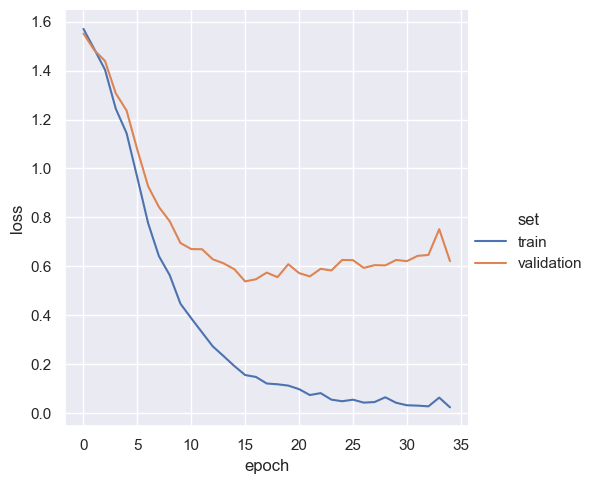

In [12]:
g = sns.relplot(history, x="epoch", y="loss", hue="set", kind="line")

In [13]:
test_loader = DataLoader(test_data, batch_size=len(test_data))
inputs, targets = next(iter(test_loader))
targets = targets.argmax(dim=1).numpy()
preds = model.predict(inputs).numpy()

print("Classification report on test set")
print(classification_report(targets, preds))

Classification report on test set
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       882
           1       0.85      0.90      0.88      1053
           2       0.75      0.65      0.70       246
           3       0.88      0.82      0.85       392
           4       0.85      0.78      0.81       323
           5       0.69      0.72      0.71       104

    accuracy                           0.85      3000
   macro avg       0.82      0.80      0.81      3000
weighted avg       0.85      0.85      0.85      3000

